<a href="https://colab.research.google.com/github/Ausmints/demo-repo/blob/main/Travel_insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Title

Explanation

##Setting up the Data

First we need to import the libraries we will be using as well as the data. Also, we will be getting the data straight from kaggle, so we need to set up the connection to kaggle as well.

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download tejashvi14/travel-insurance-prediction-data
! unzip /content/travel-insurance-prediction-data.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/13.0k [00:00<?, ?B/s]
100% 13.0k/13.0k [00:00<00:00, 9.94MB/s]
Archive:  /content/travel-insurance-prediction-data.zip
  inflating: TravelInsurancePrediction.csv  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import re
from AUS_Functions import *

In [ ]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from scipy.stats import normaltest
from scipy.stats import shapiro
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
sns.set()
colors = {
    "blue": "#4C72B0",
    "orange": "#DD8452",
    "green": "#55A868",
    "red": "#C44E52",
    "grey": "#8C8C8C",
}

In [ ]:
data = pd.read_csv("TravelInsurancePrediction.csv", index_col=0)

We need to split the dataset in training and test segments before we start EDA. However let's have a quick look at the data before we do that to make sure we split the data fairly.

In [ ]:
data.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


There is no time data and all the rows seem to be independent from each other.

Let's also quickly transform all column names to snake case.

In [ ]:
rename_columns = {}
for column in data.columns:
  name = re.sub(r' ', '', column)
  name = re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower()
  rename_columns[column] = name
data = data.rename(columns=rename_columns)

In [ ]:
data.shape

(1987, 9)

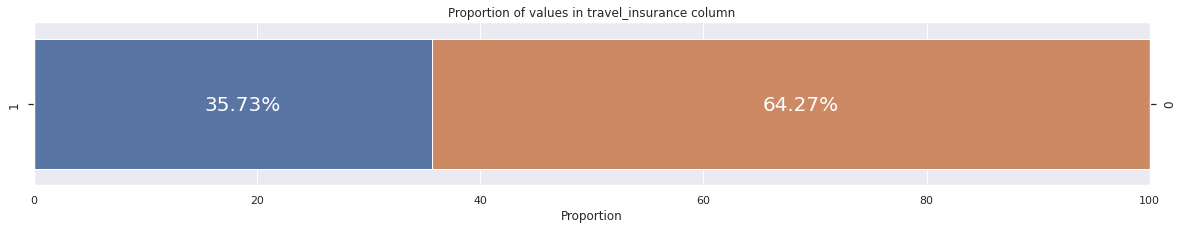

In [ ]:
draw_proportion_barplot(data["travel_insurance"].value_counts(), ["Proportion of values in travel_insurance column", "Proportion", "", ""])

As we can see, the data in the target column is distributed between the classes unequaly. To mitigate this, we will use stratified split.

In [ ]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42, stratify=data["travel_insurance"])

Since the dataset is not too large, we will use cross validation instead of hold out sample for model validation - so no more splitting is needed. 

Let's move on to the EDA part.

##EDA

In [ ]:
train_set.head()

,age,employment_type,graduate_or_not,annual_income,family_members,chronic_diseases,frequent_flyer,ever_travelled_abroad,travel_insurance
1617,28,Private Sector/Self Employed,Yes,1150000,7,1,No,No,0
675,27,Private Sector/Self Employed,No,350000,3,0,No,No,0
127,27,Government Sector,Yes,750000,5,0,No,No,0
1334,25,Government Sector,Yes,750000,3,0,No,Yes,1
1425,28,Government Sector,Yes,600000,4,0,No,No,0


In [ ]:
train_set.isnull().sum().sum()

0

There are no missing values in the dataset.

Let's explore the features one by one.

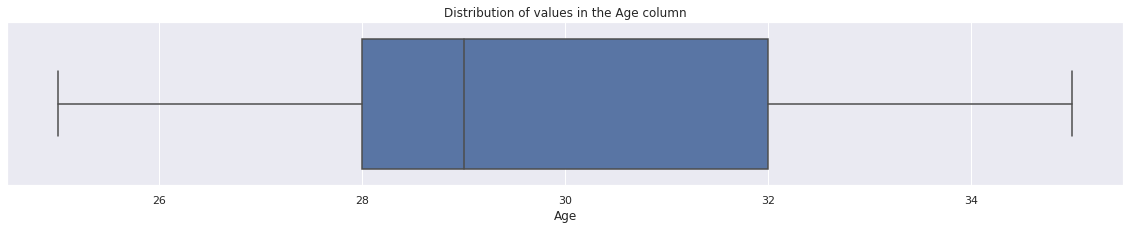

In [ ]:
draw_boxplot(train_set, "age", ["Distribution of values in the Age column", "Age", ""])

As we can see the age of customers range from 25 to 35 with the majority being 28 - 30 years old.

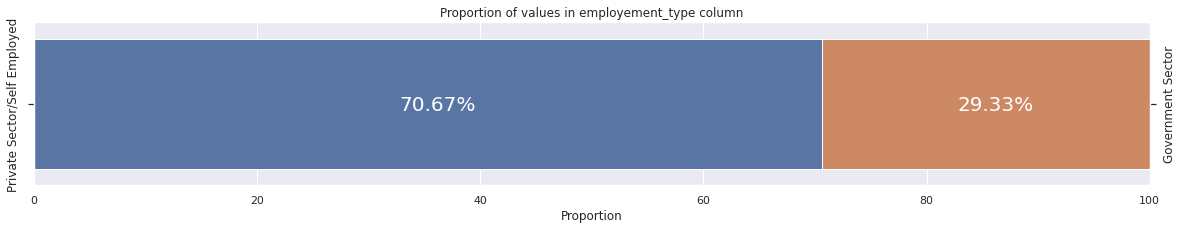

In [ ]:
draw_proportion_barplot(train_set["employment_type"].value_counts().sort_values(ascending=True), ["Proportion of values in employement_type column", "Proportion", "", ""])

Majority of the customers work in private sector, while about a third is employed by the governement.

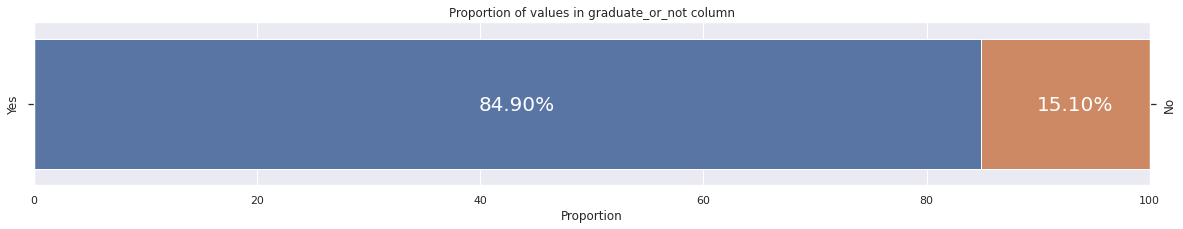

In [ ]:
draw_proportion_barplot(train_set["graduate_or_not"].value_counts().sort_values(ascending=True), ["Proportion of values in graduate_or_not column", "Proportion", "", ""])

Almost all of the customers have graduated college.

In [ ]:
train_set["scaled_annual_income"] = train_set["annual_income"]/1000000

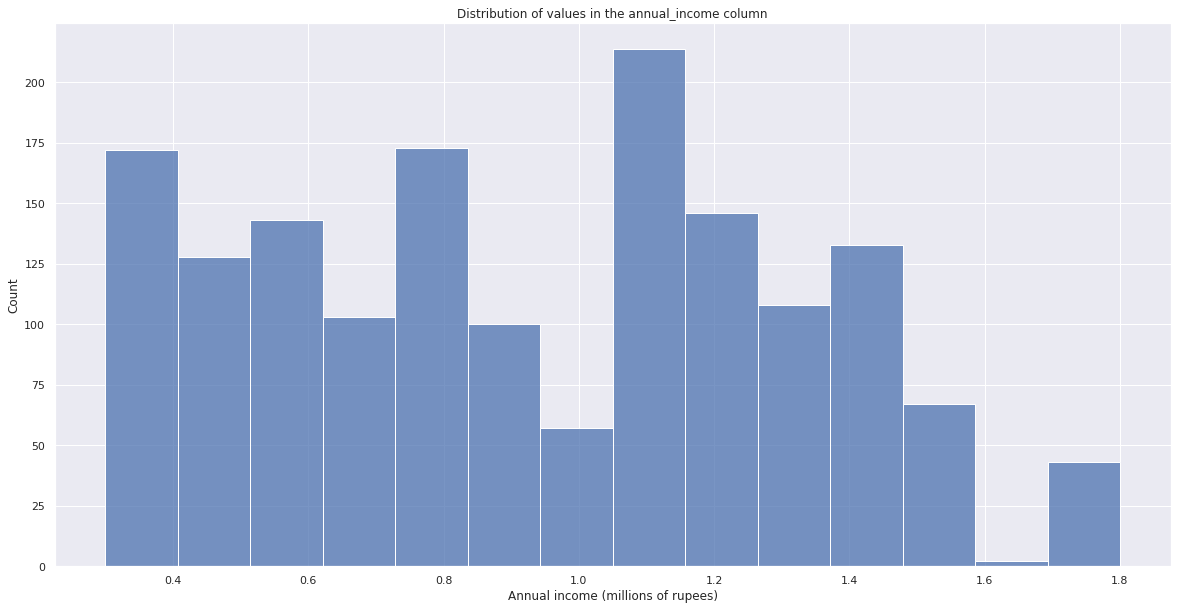

In [ ]:
draw_histplot(train_set, "scaled_annual_income", ["Distribution of values in the annual_income column", "Annual income (millions of rupees)", "Count"])

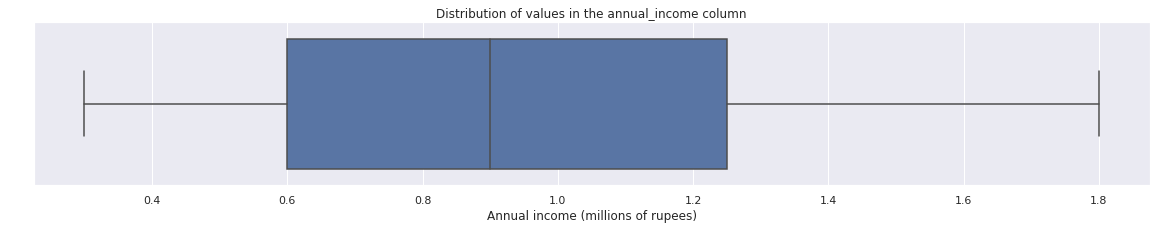

In [ ]:
draw_boxplot(train_set, "scaled_annual_income", ["Distribution of values in the annual_income column", "Annual income (millions of rupees)", " "])

The annual income seems to be slightly right skewed with the mean at about 0.9 million rupees (approx. 11,600 USD) and min as low as 0.3 million rupees (approx. 3,900 USD).

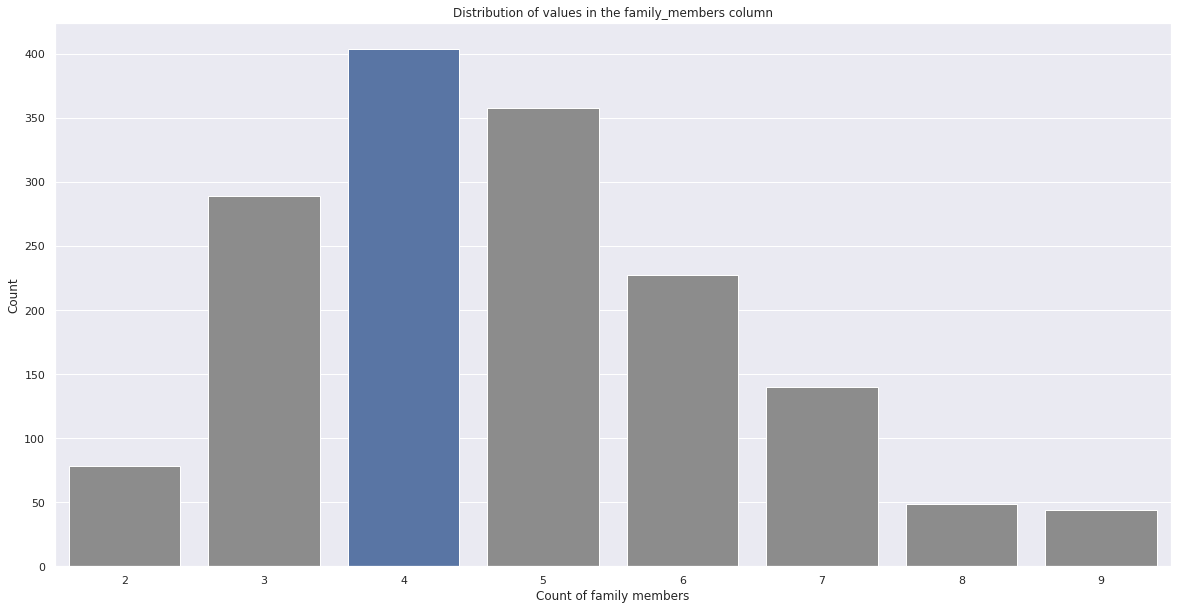

In [ ]:
temp = train_set["family_members"].value_counts().to_frame().reset_index().rename(columns={"family_members":"count", "index":"family_members"})
draw_color_barplot(temp, "family_members", "count", "family_members",  ["Distribution of values in the family_members column", "Count of family members", "Count"], [4])

Most of the customers have from 3 to 5 members in their family, but some have as many as 9.

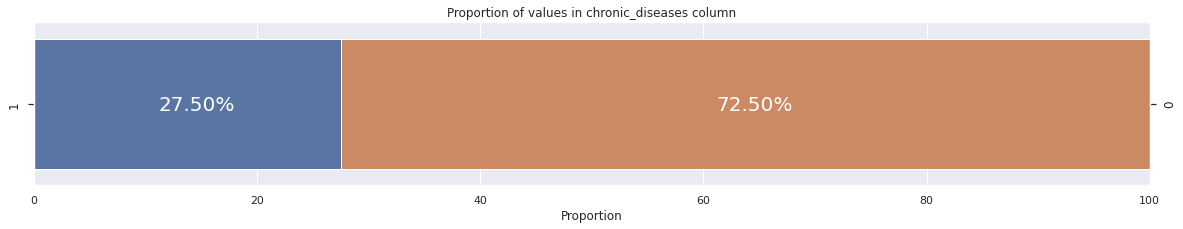

In [ ]:
draw_proportion_barplot(train_set["chronic_diseases"].value_counts(), ["Proportion of values in chronic_diseases column", "Proportion", "", ""])

Slightly less than a third of the customers have reported that they have a chronic illness.

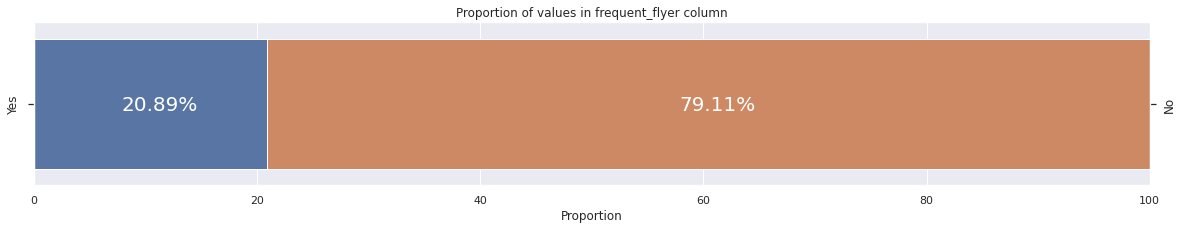

In [ ]:
draw_proportion_barplot(train_set["frequent_flyer"].value_counts(), ["Proportion of values in frequent_flyer column", "Proportion", "", ""])

Only 20 % of customers are frequent flyers.

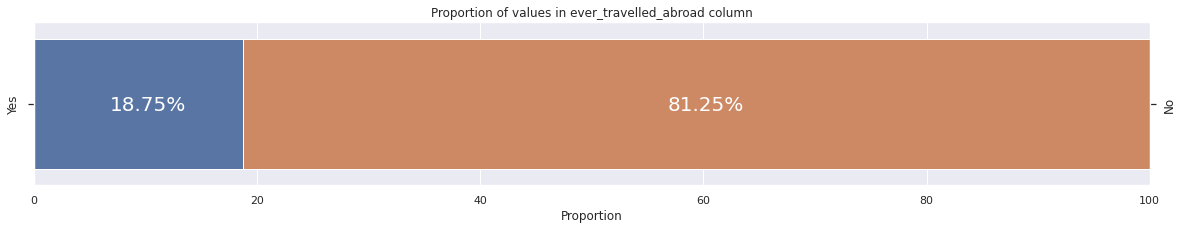

In [ ]:
draw_proportion_barplot(train_set["ever_travelled_abroad"].value_counts(), ["Proportion of values in ever_travelled_abroad column", "Proportion", "", ""])

And also only about 20% of the customers have ever traveled abroad.

Let's test some hypothesis before moving forward!

In [ ]:
train_set.head()

,age,employment_type,graduate_or_not,annual_income,family_members,chronic_diseases,frequent_flyer,ever_travelled_abroad,travel_insurance,scaled_annual_income
1617,28,Private Sector/Self Employed,Yes,1150000,7,1,No,No,0,1.15
675,27,Private Sector/Self Employed,No,350000,3,0,No,No,0,0.35
127,27,Government Sector,Yes,750000,5,0,No,No,0,0.75
1334,25,Government Sector,Yes,750000,3,0,No,Yes,1,0.75
1425,28,Government Sector,Yes,600000,4,0,No,No,0,0.60


*Considering customers that have and those that haven't bought travel insurance, does the annual income differ substantially between the two groups?*

**Null hypothesis**: The annual income is the same for both customers that bought the insurance as well as those who didn't.

**Alternative hypothesis**: The customers that bought insurance have a larger mean annual income than those who didn't.

The sample size is big enough that we don't need to worry about normalty of our data.

In [ ]:
ins_true = train_set.loc[train_set["travel_insurance"] == 1, "annual_income"]
ins_false = train_set.loc[train_set["travel_insurance"] == 0, "annual_income"]
sm.stats.CompareMeans.from_data(ins_false, ins_true).ztest_ind(usevar="unequal", alternative="smaller")

(-16.942732795918218, 1.0888447973073454e-64)

Unsuprisingly, the people with a larger annual income seem to be more likely to buy insurance.

*Considering the customers that have and those that haven't bought travel insurance, does the proportion of customers that are frequent fliers differ substantially between the two groups?*

**Null hypothesis**: The proportion of frequent fliers is the same in both groups

**Alternative hypothesis**: The proportion of frequent fliers is larger in the group of customers that have bought insurance

In [ ]:
ins_true = train_set.loc[train_set["travel_insurance"] == 1, "frequent_flyer"]
ins_false = train_set.loc[train_set["travel_insurance"] == 0, "frequent_flyer"]
sm.stats.proportions_ztest(count=[ins_false.value_counts()[1], ins_true.value_counts()[1]], nobs=[ins_false.shape[0], ins_true.shape[0]], alternative="smaller")

(-9.054538691032716, 6.857312804753349e-20)

And again the p-value is miniscule and we can accept the alternative hypothesis.

Let's plot the data concerning these two hypothesis!

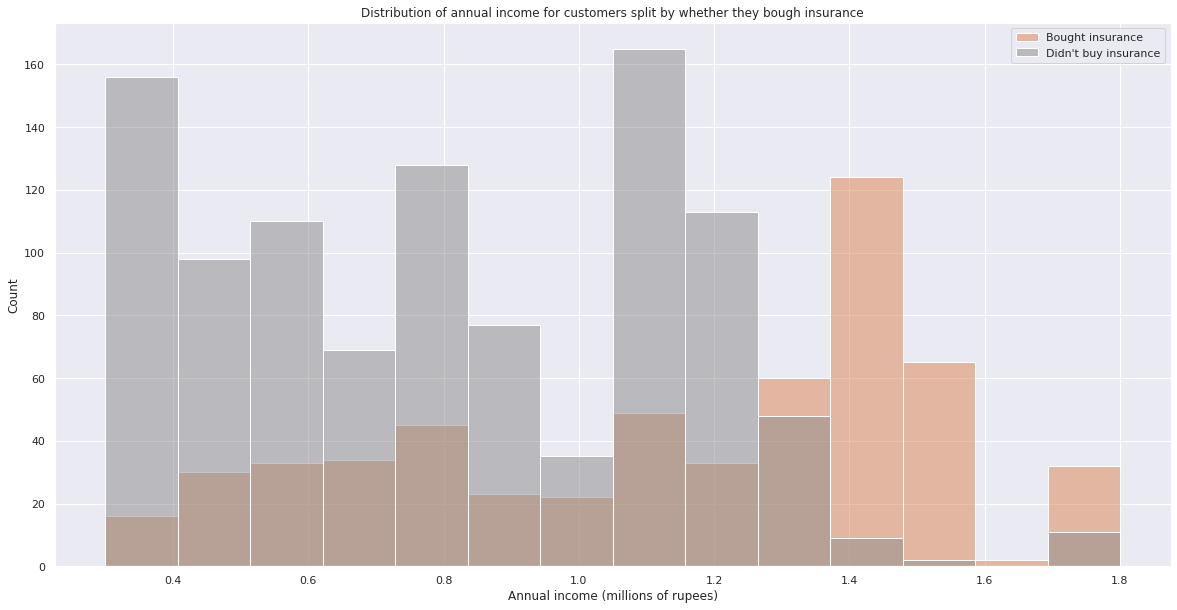

In [ ]:
draw_histplot(train_set, "scaled_annual_income", ["Distribution of annual income for customers split by whether they bough insurance", "Annual income (millions of rupees)", "Count", "Bought insurance", "Didn't buy insurance"], hue_param="travel_insurance")

In [ ]:
train_set = train_set.drop("scaled_annual_income", axis=1)

It's quite clear that our alternative for the first hypothesis was true. We can see two quite pronounced oppositely skewed distributions - distribution for customers who bought insurance is left skewed and for those who didn't, right skewed. Annual income is likely to be an important feature for the model.

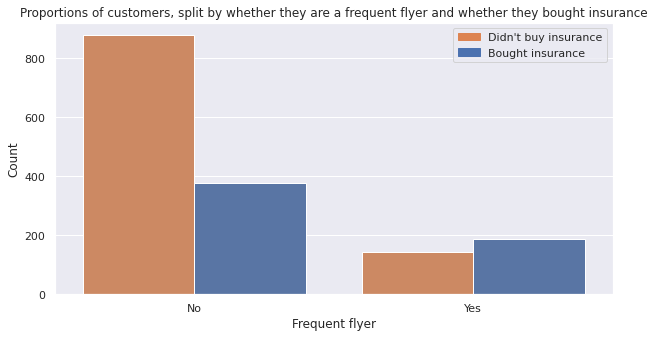

In [ ]:
draw_comparison_barplot(train_set, "travel_insurance", "frequent_flyer", [], ["Proportions of customers, split by whether they are a frequent flyer and whether they bought insurance", "Frequent flyer", "Count", "Didn't buy insurance", "Bought insurance"], largefig=False)

As for second hypothesis, even though customers who are frequent fliers are much more likely to get insurance than those who are not, this feature might not be as important due to the small proportion of frequent fliers - there are more non-frequent fliers that bought insurance than frequent fliers altogether.

Let's look at some of the other features split by whether customer bought insurance.

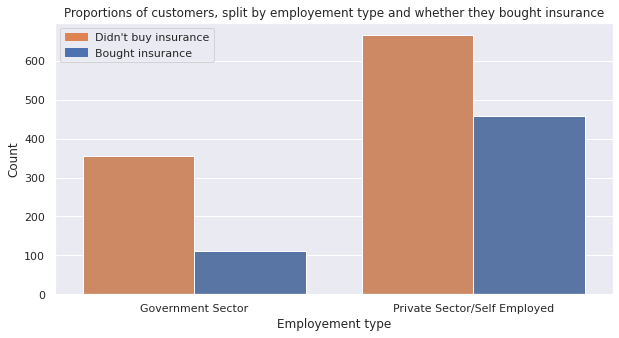

In [ ]:
draw_comparison_barplot(train_set, "travel_insurance", "employment_type", [], ["Proportions of customers, split by employement type and whether they bought insurance", "Employement type", "Count", "Didn't buy insurance", "Bought insurance"], largefig=False)

Interesting to notice that government employees seem to be a lot less likely to buy insurance than the private citizens. It could be due to government buying the insurance for the employees and that not being shown here. 

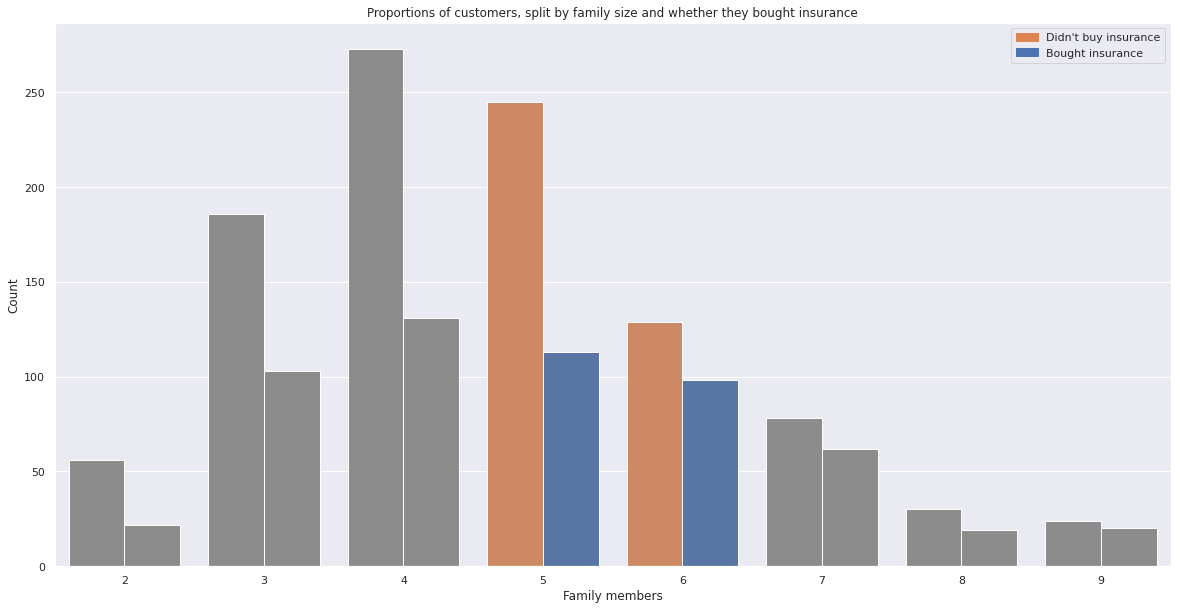

In [ ]:
draw_comparison_barplot(train_set, "travel_insurance", "family_members", [5, 6], ["Proportions of customers, split by family size and whether they bought insurance", "Family members", "Count", "Didn't buy insurance", "Bought insurance"])

Contrary to what I expected, people with more family members seem to be more likely to buy insurance than those with less. There seems to be a substantial increase in insurance purchases between 5 and 6 family members.

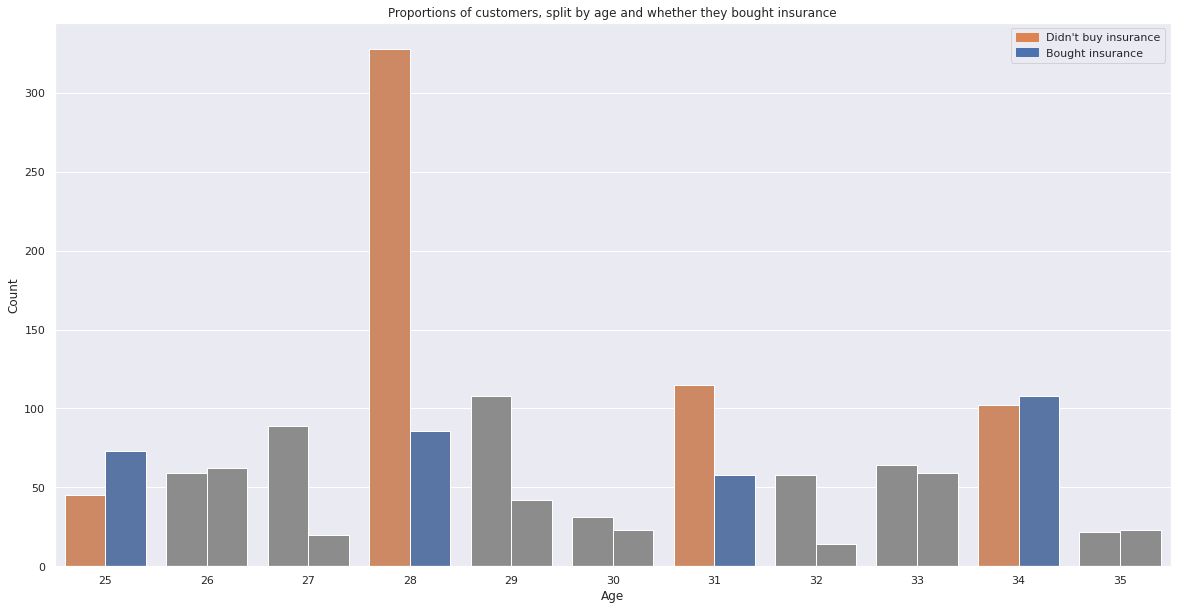

In [ ]:
draw_comparison_barplot(train_set, "travel_insurance", "age", [25, 28, 31, 34], ["Proportions of customers, split by age and whether they bought insurance", "Age", "Count", "Didn't buy insurance", "Bought insurance"])

It's hard to discern any clear patterns in this age graph. Seems like people are more likely than not to buy insurance at around ages 25 and 34, but very unlikely in between these ages. This data doesn't really make sense, especially the massive spike in age 28. One possible explanation might be some kind of sampling bias when gathering the data - I have no information of methods used to gather this information and what was the selection process for the people that got offered the insurance deal. Another possibility might be an unfortunate split between test and training data with the split uneven in the age dimension. Whatever the case, we might want to exclude age column when building the models.

##Feature engineering

I doesn't seem that much feature engineering is needed. There are no missing values, the amount of features is quite small and they seem to be quite unrelated to one another. The only things we'll do are convert the columns containing strings in two categories to binary values, as well as scale the numerical columns. Let's create a pipeline that takes care of these things!

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


In [ ]:
transform_pipeline = Pipeline([
        ('to_numeric', CategoryToNumeric()),
        ('minmax_scaler', MinMaxScaler()),
    ])

##Model training

Let's get to the modelling. 

While the objective is to correctly predict whether a customer would or would not buy insurance, we are more interested in the customers that do buy the insurance. Also, since, in this case, a false positive (offering a customer insurance that does not result in a purchase) is a less painful error than a false negative (passing on a customer that would have resulted on a sale), we are more interested in recall than precision or accuracy.

First, let's go through a few classification algorithms in their default configuration to see approximately how well they fit to the data.

In [ ]:
models = [["svm_rbf", SVC()], ["svm_poly", SVC(kernel="poly")], ["k-neighbors", KNeighborsClassifier()], ["logistic_reg", LogisticRegression()], ["decision_tree", DecisionTreeClassifier()], ["random_forest", RandomForestClassifier()],  ["boosted_model", GradientBoostingClassifier()]]

for model in models:
  pipe = Pipeline([
          ('transform', transform_pipeline),
          (model[0], model[1]),
  ])
  temp = cross_val_score(pipe, train_set.iloc[:, :-1], train_set.iloc[:, -1], cv=4, scoring="recall")
  print(model[0], temp, " | ", temp.mean())

svm_rbf [0.42253521 0.49295775 0.46478873 0.52816901]  |  0.477112676056338
svm_poly [0.47183099 0.52112676 0.5        0.58450704]  |  0.5193661971830986
k-neighbors [0.54225352 0.62676056 0.54225352 0.58450704]  |  0.573943661971831
logistic_reg [0.40140845 0.49295775 0.46478873 0.5       ]  |  0.4647887323943662
decision_tree [0.6056338  0.62676056 0.58450704 0.66901408]  |  0.6214788732394365
random_forest [0.61267606 0.65492958 0.63380282 0.64084507]  |  0.6355633802816902
boosted_model [0.57042254 0.63380282 0.5915493  0.5915493 ]  |  0.596830985915493


We can see that the best models for this data seem to be Decision tree and Random forest. K-neighbors and boosted model also seem decent. However, the recall value is not very high for any of them.

Let's check how the models work without the sketchy "age" column.

In [ ]:
for model in models:
  pipe = Pipeline([
          ('transform', transform_pipeline),
          (model[0], model[1]),
  ])
  temp = cross_val_score(pipe, train_set.iloc[:, 1:-1], train_set.iloc[:, -1], cv=4, scoring="recall")
  print(model[0], temp, " | ", temp.mean())

svm_rbf [0.41549296 0.48591549 0.43661972 0.51408451]  |  0.4630281690140845
svm_poly [0.41549296 0.48591549 0.46478873 0.50704225]  |  0.46830985915492956
k-neighbors [0.52112676 0.52816901 0.52816901 0.54929577]  |  0.5316901408450704
logistic_reg [0.43661972 0.49295775 0.47887324 0.51408451]  |  0.4806338028169014
decision_tree [0.54225352 0.55633803 0.56338028 0.64084507]  |  0.5757042253521127
random_forest [0.6056338  0.57746479 0.56338028 0.61971831]  |  0.5915492957746479
boosted_model [0.50704225 0.49295775 0.51408451 0.54225352]  |  0.5140845070422535


Interesting thing to notice - Logistic regression actually performs better without the "age" column. However for the other models the recall value is lower compared to when using all features.

The most promising model seemed to be Random Forest. Let's try tuning it's hyperparameters to see if we can make it even better.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = [
    {"random_forest__n_estimators": [200], "random_forest__criterion": ["gini", "entropy"], "random_forest__max_depth": [None, 3, 8], 'random_forest__max_features': [0.2, 0.5, None, "sqrt"], "random_forest__min_samples_leaf": [1, 5, 10, 20], "random_forest__random_state": [42]}
  ]

pipe = Pipeline([
        ('transform', transform_pipeline),
        ("random_forest", RandomForestClassifier()),
  ])

grid_search = GridSearchCV(pipe, param_grid, cv=5,
                           scoring='recall',
                           return_train_score=True)

grid_search.fit(train_set.iloc[:, :-1], train_set.iloc[:, -1])
grid_df = pd.DataFrame(grid_search.cv_results_)
grid_search_results_to_df(grid_search.cv_results_, "random_forest")

,mean_test_score,mean_train_score,criterion,max_depth,max_features,min_samples_leaf,n_estimators,random_state
0,0.649651,0.841106,entropy,NaN,None,1,200,42
1,0.647896,0.841549,gini,NaN,None,1,200,42
2,0.639124,0.839786,entropy,NaN,0.5,1,200,42
3,0.639109,0.839346,gini,NaN,0.5,1,200,42
4,0.635569,0.841548,entropy,NaN,sqrt,1,200,42
5,0.633830,0.841988,gini,NaN,0.2,1,200,42
6,0.633830,0.838465,gini,NaN,sqrt,1,200,42
7,0.630290,0.839786,entropy,NaN,0.2,1,200,42
8,0.598587,0.630716,entropy,NaN,None,5,200,42
9,0.598572,0.628081,entropy,8.0,sqrt,1,200,42


We've displayed only the top 10 results. 

We can see that with "min_samples_leaf" as 1 the difference between the test and train scores is quite vast, thus indicating overfitting. However the test score is also highest with that value, so maybe it also allows for the underlying patterns to be clearer. 

Now that we've got a rough estimate for the best values for numerical parameters, let's try to tune them a bit more by looking at the numerical values around the best estimates we got.

In [ ]:
param_grid = [
    {"random_forest__n_estimators": [200], "random_forest__criterion": ["gini", "entropy"], "random_forest__max_depth": [None, 9, 10], 'random_forest__max_features': [0.2, 0.5, 0.8, None, "sqrt"], "random_forest__min_samples_leaf": [1, 2, 3], "random_forest__random_state": [42]}
  ]

grid_search = GridSearchCV(pipe, param_grid, cv=5,
                           scoring='recall',
                           return_train_score=True)

grid_search.fit(train_set.iloc[:, :-1], train_set.iloc[:, -1])
grid_search_results_to_df(grid_search.cv_results_, "random_forest")

,mean_test_score,mean_train_score,criterion,max_depth,max_features,min_samples_leaf,n_estimators,random_state
0,0.649651,0.841106,entropy,None,None,1,200,42
1,0.647896,0.841549,gini,None,None,1,200,42
2,0.646142,0.842866,entropy,None,0.8,1,200,42
3,0.642618,0.841546,gini,None,0.8,1,200,42
4,0.639124,0.839786,entropy,None,0.5,1,200,42
5,0.639109,0.839346,gini,None,0.5,1,200,42
6,0.635569,0.841548,entropy,None,sqrt,1,200,42
7,0.635507,0.735478,gini,None,None,2,200,42
8,0.635491,0.741197,entropy,None,None,2,200,42
9,0.633830,0.841988,gini,None,0.2,1,200,42


Seems like we did not manage to find any better values than we got previously. Let's see what the accuracy looks like for the best model!

In [ ]:
pipe = Pipeline([
        ('transform', transform_pipeline),
        ("random_forest", RandomForestClassifier(criterion="entropy", max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=200))
  ])
temp = cross_val_score(pipe, train_set.iloc[:, :-1], train_set.iloc[:, -1], cv=4, scoring="accuracy")
print("random_forest", temp, " | ", temp.mean())

random_forest [0.77889447 0.7884131  0.80100756 0.78085642]  |  0.7872928876118628


So the current best model has 0.64 recall and 0.79 accuracy - while a long shot from perfect score, it's a lot better than the default 50/50 chance.

Since our target column is unevenly split, we should try adding weights. Let's see if a better model can be found.

In [ ]:
pipe = Pipeline([
        ('transform', transform_pipeline),
        ("random_forest", RandomForestClassifier(criterion="entropy", max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=200, class_weight="balanced"))
  ])
temp = cross_val_score(pipe, train_set.iloc[:, :-1], train_set.iloc[:, -1], cv=4, scoring="recall")
print("random_forest", temp, " | ", temp.mean())

random_forest [0.61971831 0.66901408 0.64084507 0.66197183]  |  0.647887323943662


In [ ]:
pipe = Pipeline([
        ('transform', transform_pipeline),
        ("random_forest", RandomForestClassifier(criterion="entropy", max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=200, class_weight="balanced"))
  ])
temp = cross_val_score(pipe, train_set.iloc[:, :-1], train_set.iloc[:, -1], cv=4, scoring="accuracy")
print("random_forest", temp, " | ", temp.mean())

random_forest [0.77135678 0.77078086 0.78589421 0.7581864 ]  |  0.7715545612191942


We can see, that the recall score is slightly better than without the weights - with a small cost on accuracy. 

Let's try tuning the hyperparameters for some of the other promising algorithms to see whether we can get a better recall value with any of those.

In [ ]:
param_grid = [
    {"decision_tree__criterion": ["gini", "entropy"], "decision_tree__max_depth": [None, 3, 8], "decision_tree__max_features": [0.2, 0.5, 0.8, None, "sqrt"], "decision_tree__min_samples_leaf": [1, 5, 10, 20], "decision_tree__class_weight": ["balanced", None], "decision_tree__random_state": [42]}
  ]

pipe = Pipeline([
      ('transform', transform_pipeline),
      ("decision_tree", DecisionTreeClassifier()),
])

grid_search = GridSearchCV(pipe, param_grid, cv=5,
                           scoring='recall',
                           return_train_score=True)

grid_search.fit(train_set.iloc[:, :-1], train_set.iloc[:, -1])
grid_search_results_to_df(grid_search.cv_results_, "decision_tree")

,mean_test_score,mean_train_score,class_weight,criterion,max_depth,max_features,min_samples_leaf,random_state
0,0.704192,0.817344,balanced,gini,NaN,NaN,5,42
1,0.698944,0.827026,balanced,entropy,NaN,NaN,5,42
2,0.697081,0.807222,balanced,gini,NaN,0.8,5,42
3,0.691818,0.753519,balanced,entropy,NaN,NaN,10,42
4,0.688278,0.753949,balanced,entropy,NaN,0.8,10,42
5,0.686648,0.805008,balanced,entropy,NaN,0.8,5,42
6,0.684785,0.746919,balanced,gini,NaN,NaN,10,42
7,0.683139,0.786537,balanced,entropy,NaN,0.5,5,42
8,0.679475,0.740741,balanced,gini,NaN,0.8,10,42
9,0.677612,0.684897,balanced,gini,3.0,0.2,5,42


In [ ]:
param_grid = [
    {"decision_tree__criterion": ["gini", "entropy"], "decision_tree__max_features": [0.2, 0.5, 0.8, None, "sqrt"], "decision_tree__min_samples_leaf": [3, 4, 5, 6, 8, 9, 10, 11, 12], "decision_tree__class_weight": ["balanced"], "decision_tree__random_state": [42]}
  ]

pipe = Pipeline([
      ('transform', transform_pipeline),
      ("decision_tree", DecisionTreeClassifier()),
])

grid_search = GridSearchCV(pipe, param_grid, cv=5,
                           scoring='recall',
                           return_train_score=True)

grid_search.fit(train_set.iloc[:, :-1], train_set.iloc[:, -1])
grid_search_results_to_df(grid_search.cv_results_, "decision_tree")

,mean_test_score,mean_train_score,class_weight,criterion,max_features,min_samples_leaf,random_state
0,0.707747,0.830551,balanced,gini,NaN,4,42
1,0.705946,0.829239,balanced,gini,NaN,3,42
2,0.704192,0.817344,balanced,gini,NaN,5,42
3,0.700730,0.835828,balanced,entropy,NaN,4,42
4,0.698944,0.827026,balanced,entropy,NaN,5,42
5,0.697128,0.813397,balanced,gini,0.8,4,42
6,0.697081,0.807222,balanced,gini,0.8,5,42
7,0.695435,0.814273,balanced,entropy,0.8,4,42
8,0.693650,0.790488,balanced,entropy,0.8,6,42
9,0.691818,0.753519,balanced,entropy,NaN,10,42


In [ ]:
pipe = Pipeline([
        ('transform', transform_pipeline),
        ("decision_tree", DecisionTreeClassifier(criterion="gini", max_depth=None, max_features=None, min_samples_leaf=4))
  ])
temp = cross_val_score(pipe, train_set.iloc[:, :-1], train_set.iloc[:, -1], cv=4, scoring="accuracy")
print("decision_tree", temp, " | ", temp.mean())

decision_tree [0.80904523 0.84382872 0.79848866 0.79596977]  |  0.8118330949457615


In [ ]:
param_grid = [
    {"k_neighbors__n_neighbors":[2, 4, 7, 10, 13, 17, 20], "k_neighbors__weights": ["uniform", "distance"], "k_neighbors__metric":  ["euclidean", "manhattan", "minkowski"]}
  ]

pipe = Pipeline([
      ('transform', transform_pipeline),
      ("k_neighbors", KNeighborsClassifier()),
])

grid_search = GridSearchCV(pipe, param_grid, cv=5,
                           scoring='recall',
                           return_train_score=True)

grid_search.fit(train_set.iloc[:, :-1], train_set.iloc[:, -1])
grid_search_results_to_df(grid_search.cv_results_, "k_neighbors")

,mean_test_score,mean_train_score,metric,n_neighbors,weights
0,0.625043,0.817781,manhattan,4,distance
1,0.616271,0.801051,manhattan,2,distance
2,0.612715,0.817781,euclidean,4,distance
3,0.612715,0.817781,minkowski,4,distance
4,0.610961,0.817781,manhattan,7,distance
5,0.609191,0.817781,manhattan,10,distance
6,0.607483,0.801051,minkowski,2,distance
7,0.607483,0.801051,euclidean,2,distance
8,0.605682,0.817781,minkowski,7,distance
9,0.605682,0.817781,euclidean,7,distance


In [ ]:
param_grid = [
    {"k_neighbors__n_neighbors":[2, 3, 4, 5, 6], "k_neighbors__weights": ["distance"], "k_neighbors__metric":  ["euclidean", "manhattan", "minkowski"]}
  ]

pipe = Pipeline([
      ('transform', transform_pipeline),
      ("k_neighbors", KNeighborsClassifier()),
])

grid_search = GridSearchCV(pipe, param_grid, cv=5,
                           scoring='recall',
                           return_train_score=True)

grid_search.fit(train_set.iloc[:, :-1], train_set.iloc[:, -1])
grid_search_results_to_df(grid_search.cv_results_, "k_neighbors")

,mean_test_score,mean_train_score,metric,n_neighbors,weights
0,0.632107,0.839351,manhattan,3,distance
1,0.625043,0.817781,manhattan,4,distance
2,0.618025,0.839351,euclidean,3,distance
3,0.618025,0.819102,manhattan,5,distance
4,0.618025,0.839351,minkowski,3,distance
5,0.616271,0.801051,manhattan,2,distance
6,0.612762,0.819102,euclidean,5,distance
7,0.612762,0.819102,minkowski,5,distance
8,0.612715,0.817781,euclidean,4,distance
9,0.612715,0.817781,manhattan,6,distance


In [ ]:
pipe = Pipeline([
        ('transform', transform_pipeline),
        ("decision_tree", KNeighborsClassifier(n_neighbors=3, metric="manhattan", weights="distance"))
  ])
temp = cross_val_score(pipe, train_set.iloc[:, :-1], train_set.iloc[:, -1], cv=4, scoring="accuracy")
print("decision_tree", temp, " | ", temp.mean())

decision_tree [0.74874372 0.74559194 0.76826196 0.75566751]  |  0.7545662822930775


In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
neighbors = KNeighborsClassifier(n_neighbors=3, metric="manhattan", weights="distance")
forest = RandomForestClassifier(criterion="entropy", max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=200, class_weight="balanced")
tree = DecisionTreeClassifier(criterion="gini", max_depth=None, max_features=None, min_samples_leaf=4)

pipe = Pipeline([
        ('transform', transform_pipeline),
        ("decision_tree", VotingClassifier(estimators=[('k-neighbors', neighbors), ('rf', forest), ('tree', tree)], voting='hard'))
  ])
temp = cross_val_score(pipe, train_set.iloc[:, :-1], train_set.iloc[:, -1], cv=4, scoring="recall")
print("decision_tree", temp, " | ", temp.mean())

decision_tree [0.61971831 0.64788732 0.62676056 0.65492958]  |  0.6373239436619719


In [ ]:
pipe = Pipeline([
        ('transform', transform_pipeline),
        ("decision_tree", VotingClassifier(estimators=[('k-neighbors', neighbors), ('rf', forest), ('tree', tree)], voting='hard'))
  ])
temp = cross_val_score(pipe, train_set.iloc[:, :-1], train_set.iloc[:, -1], cv=4, scoring="accuracy")
print("decision_tree", temp, " | ", temp.mean())

decision_tree [0.77135678 0.79596977 0.79596977 0.78085642]  |  0.7860381884232245
